# Code setup

In [1]:
try:
    %load_ext lab_black
except ModuleNotFoundError:
    print("Couldn't load Black autoformatter.")

In [2]:
# To suppress warning output
import warnings

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import math

# Set random seed across notebook for repeatable results
np.random.seed(1922)  # for Papa

In [3]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

matplotlib.rcParams["font.family"] = ["sans-serif"]
matplotlib.rcParams["font.sans-serif"] = [
    "Source Sans 3",
    "Helvetica",
    "Arial",
    "sans-serif",
]
plt.rcParams["axes.titlesize"] = "x-large"  # 16
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)):
    print("Figure directory did not exist, creating now.")
    os.mkdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)
else:
    print("Figure directory exists.")

Figure directory exists.


In [30]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.


<module 'functions' from '/Users/blt/Documents/ml-weight-fraction/functions.py'>

# Data

In [6]:
# Target (ENM) data

# Read in ENM feature data
X_enm = pd.read_csv(
    "./data/ENM-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in ENM labels (maximum_weight_fraction)
y_enm = pd.read_csv("./data/ENM-clean.csv", sep=",", header="infer", usecols=[4])
print("X_enm shape:", X_enm.shape)
print("y_enm shape:", y_enm.shape)

X_enm shape: (112, 53)
y_enm shape: (112, 1)


In [7]:
# Source (bulk organics) data

# Read in source feature data
X_source = pd.read_csv(
    "./data/organics-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in source labels (maximum_weight_fraction)
y_source = pd.read_csv(
    "./data/organics-preprocessed-WF.csv", sep="\t", header="infer", index_col=0
)
y_source.index = X_source.index
print("X_source shape:", X_source.shape)
print("y_source shape:", y_source.shape)

X_source shape: (16439, 53)
y_source shape: (16439, 1)


In [8]:
# View ENM feature df
X_enm.head(4)

,cprp_MW,cprp_MP,cprp_BP,cprp_density,func_absorbent,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,func_biocide,func_brightener,...,pgrp_makeuprelated,pgrp_nutritionalsupplements,pgrp_paintstainrelated,pgrp_portableairprocessing,pgrp_sunscreen,pgrp_surfacesealers,pgrp_toys,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,2972.0,4.230,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,63.546,1083.00,2567.0,8.960,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,65.370,419.53,907.0,7.140,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,107.868,961.78,2162.0,10.345,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
# Read in previous model evaluation results tables
results_prelim = pd.read_csv("./data/results-prelim.csv", sep="\t", na_values="nan")
results_final = pd.read_csv("./data/results-final.csv", sep="\t", na_values="nan")
results_svc = pd.read_csv("./data/results-SVC.csv", sep="\t", na_values="nan")
results_rfc = pd.read_csv("./data/results-RFC.csv", sep="\t")
# results_permute = np.loadtxt("./data/results-permutation-SVC.txt")

## Apply WF bins

Labels (continuous WF data) will be binned into low (0.0-0.0001), medium (0.0001-0.01) and high (0.01-1.0) categories.

In [10]:
# Apply bins to ENM and organics data
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))
bin_source = np.asarray(y_source.apply(blt.bins, axis=1))

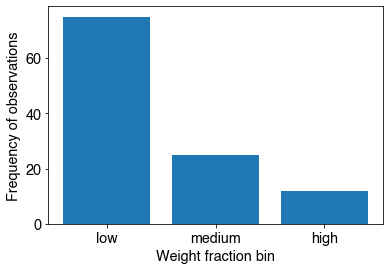

Label bin:  [0 1 2]
Count    :  [75 25 12]
Frequency:  [0.67, 0.22, 0.11]


In [11]:
# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_enm, data_composition="ENM")

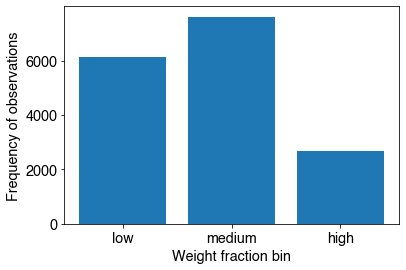

Label bin:  [0 1 2]
Count    :  [6127 7617 2695]
Frequency:  [0.37, 0.46, 0.16]


In [12]:
# View bar plot of Organics WF bins
blt.bar_graph_bins(bin_source, data_composition="Organics")

## Visualize chemical space

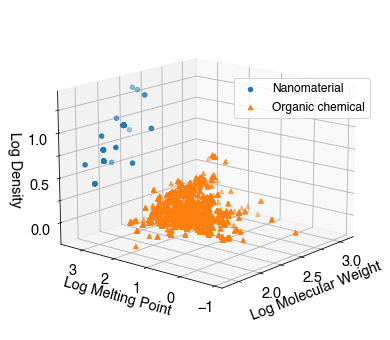

In [13]:
# Plot chemical properties of datasets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

for m, df, l in [("o", X_enm, "Nanomaterial"), ("^", X_source, "Organic chemical")]:
    mw = np.log10(df.cprp_MW)
    mp = np.log10(df.cprp_MP)
    ds = np.log10(df.cprp_density)
    ax.scatter(mw, mp, ds, marker=m, label=l)

# Axes formatting
ax.set_xlabel("Log Molecular Weight")
ax.set_ylabel("Log Melting Point")
ax.set_zlabel("Log Density")
ax.locator_params(axis="x", nbins=4)
ax.locator_params(axis="z", nbins=4)
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.zaxis.set_minor_locator(MultipleLocator(0.25))


ax.view_init(azim=-140, elev=15)  # set rotation angle of plot
ax.legend(loc="upper center", bbox_to_anchor=(0.8, 0.8), fontsize=12)
blt.savepdf(fig, "3D-chemprops")
fig.show()

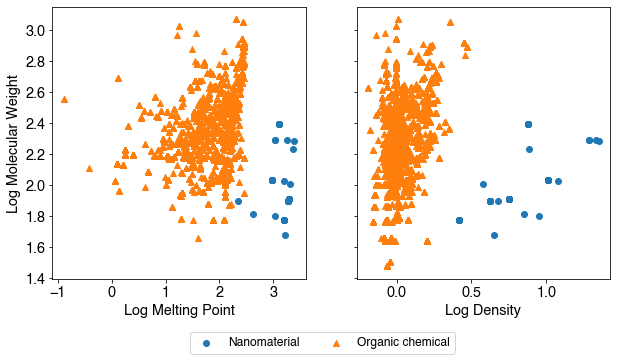

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for m, df, l in [("o", X_enm, "Nanomaterial"), ("^", X_source, "Organic chemical")]:
    mw = np.log10(df.cprp_MW)
    mp = np.log10(df.cprp_MP)
    ax1.scatter(mp, mw, marker=m, label=l)
ax1.set_ylabel("Log Molecular Weight")
ax1.set_xlabel("Log Melting Point")

for m, df, l in [("o", X_enm, "Nanomaterial"), ("^", X_source, "Organic chemical")]:
    ds = np.log10(df.cprp_density)
    mw = np.log10(df.cprp_MW)
    ax2.scatter(ds, mw, marker=m)
ax2.set_xlabel("Log Density")
fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), fontsize=12, ncol=2)

## Pre-check PCA

[0.29024958 0.40857229 0.49112146 0.56586553 0.62552707 0.67728336
 0.72335413 0.76435104 0.78726129 0.80974826 0.82771603 0.84525823
 0.85979504 0.87280657 0.88527525 0.89668188 0.90661927 0.91560422
 0.92450973 0.93242653 0.93983401 0.94630311 0.95243621 0.9585441
 0.96411347 0.96877561 0.97288469 0.97645159 0.97991518 0.98319911]


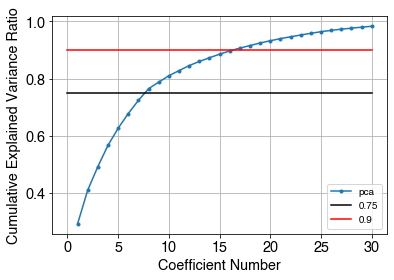

[8, 9, 10, 11, 12, 13, 14, 15, 16]


In [13]:
from sklearn.decomposition import PCA

component_list = blt.pca_precheck(
    X=X_enm, n_components=30, thres_btm=0.75, thres_top=0.90
)

# Model optimization

Modeling functions are all called from an external python file, $functions.py$, loaded at the beginning of this script. These will optimize, execute and evaluate different classifiers on several different training datasets using stratified cross validation (CV).

A machine learning pipeline is used to (optionally) augment training data with source (organic chemical products) data, normalize features on a 0 to 1 scale, reduce feature dimensionality using PCA, then run a classifer (SVC-RBF or RFC) using stratified cross validation. Model parameters are optimized using a parameter grid search.

This table summarizes what the CV pipeline does for each CV fold in terms of X/y and training/testing data. We have altered the "fit" step of sk-learn's Pipeline, which "only transform[s] the observed data (X)" (https://scikit-learn.org/stable/modules/compose.html), so that the y training data will also be transformed in the data augmentation step.

|     Pipeline Step                |     X_train                    |     y_train              |     X_test (ENM only)    |     y_test (ENM only)    |
|----------------------------------|--------------------------------|--------------------------|--------------------------|--------------------------|
|     (1) Data augmentation        |     fit, transform +mask    |     fit, transform    |                          |                          |
|     (2) Min-max scaling          |     fit, transform             |                          |     transform            |                          |
|     (3) Feature reduction    |     fit, transform       |                          |     transform            |                          |
|     (4) Classification           |     fit, predict               |     fit, predict         |     predict              |     predict              |

Unsupervised and supervised data augmentation rely on cosine similarity to determine which samples from the source dataset are most similar to each sample in the target dataset. 

$\text{cosine similarity} = \frac{A \cdotp B}{\parallel A \parallel \parallel B \parallel} $

We are assuming that the chemical properties of our source data are very different from our target data, so when looking for similar observations to pair, we want to exclude chemical properties from the similarity calculation by applying a *feature mask*. The mask will set chemical property features to zero so that they are effectively ignored by cosine similarity (only during data augmentation). Because chemical properties are the only features that aren't on a scale from 0 to 1, this also means we can perform data augmentation prior to min-max scaling in the cross validation pipeline.

Resource for writing custom sklearn transformers:
https://towardsdatascience.com/writing-custom-scikit-learn-transformers-e07a3cf7b559

In [14]:
import random as pyrandom
from numpy import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler

# Define feature mask for data augmentation
feat_names = X_enm.columns
col_mask = ["cprp" not in name for name in feat_names]


# Functions for different data augmentation methods


def random_augment(k, X_source, y_source, random_state, X, y):
    """Randomly samples source data to pair with target data."""

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Number of samples to select
    n_samples = k * len(X)
    # Obtain indices for randomly sampling source data
    idx_match = np.random.choice(len(X_source), n_samples)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    assert (
        X_aug.shape[0] == y_aug.shape[0]
    ), f"X_aug.shape={X_aug.shape}, y_aug.shape={y_aug.shape}"

    return X_aug, y_aug


def unsupervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Unsupervised data augmentation

    Match "k" most similar source data samples to target data samples
    based on the smallest cosine distance between target and source data
    samples (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in cosdist_samples.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug


def supervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Supervised data augmentation

    Match "k" most similar source data samples to target data samples
    based on the smallest average of cosine distance between samples
    and distance between WF labels (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # For supervised matching augmentation, also consider WF labels
    # Turn 1D label arrays into 2D arrays
    y_2d = np.tile(y, (len(y_source), 1))
    y_source_2d = np.tile(y_source, (len(y), 1)).transpose()
    # Get normalized distance between ENM and organics labels
    scaler = MinMaxScaler()
    dist_y = scaler.fit_transform(np.abs(y_2d - y_source_2d).astype(float))
    # Average distances of features and labels
    dist_matrix = (0.95 * cosdist_samples) + (0.05 * dist_y)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in dist_matrix.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug

In [15]:
# Define models and parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt

random_state = 1922
augmentation_kwargs = {
    "augmentation_random_state": random_state,
    "augmentation_X_source": X_source,
    "augmentation_y_source": bin_source,
}

models = {
    "RandomForestClassifier": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                RandomForestClassifier(
                    class_weight="balanced", random_state=random_state
                ),
            ),
        ],
        **augmentation_kwargs
    ),
    "SVC": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",  # balance by class size
                    random_state=random_state,
                ),
            ),
        ],
        **augmentation_kwargs
    ),
}
params = {
    "RandomForestClassifier": {
        "augmentation_type": [random_augment, unsupervised_augment, supervised_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],
        "dimreducer__n_components": component_list,
        "estimator__max_depth": np.arange(2, 19, 2),
    },
    "SVC": {
        "augmentation_type": [random_augment, unsupervised_augment, supervised_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],
        "dimreducer__n_components": component_list,
        "estimator__C": np.logspace(-1, 7, 9),
        "estimator__gamma": np.logspace(-7, 1, 9),
    },
}

In [18]:
from dask.distributed import Client
import joblib
client = Client()

with joblib.parallel_backend('dask'):
    results_prelim = blt.apply_model_opt(
        models, params, X_target=X_enm, y_target=bin_enm, cust_folds=5, n_jobs=4
    )

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=4)]: Using backend DaskDistributedBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 11.3min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 16.7min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 22.6min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 29.8min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 38.3min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 47.6min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 58.5min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 71.5min
[Parallel(n_jobs=4)]: Done 9720 out of 9720 | elapsed: 86.2min finished
[Parallel(n_jobs=4)]: Using backend Dask

Running GridSearchCV for SVC.
Fitting 5 folds for each of 17496 candidates, totalling 87480 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed:  9.0min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done 12792 tasks      | elapsed: 12.0min
[Parallel(

RandomForestClassifier
SVC


In [28]:
# Export preliminary results table to .csv
results_prelim.to_csv(
    "./data/results-prelim.csv", sep="\t", header="infer", na_rep="NaN", index=False
)

# Model evaluation

For model evaluation, optimized models are tested over 30 trials using stratified cross validation on the original ENM product data. Original data was used instead of a holdout set due to the paucity of data available. 

A normalized confusion matrix summarizes balanced accuracy results according to each WF bin (class). The average normalized balanced accuracy across all bins is then calculated from the confusion matrix.

## SVC-RBF

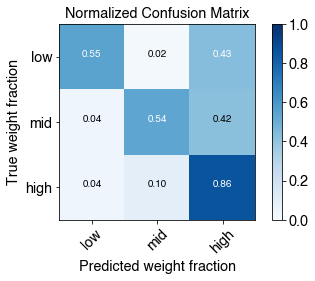

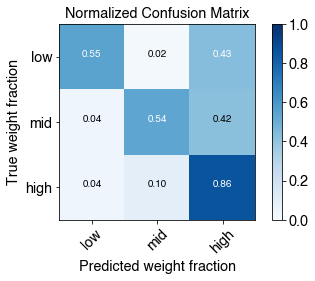

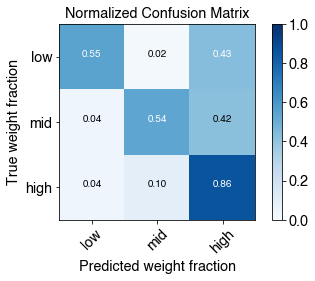

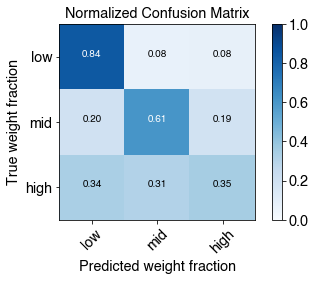

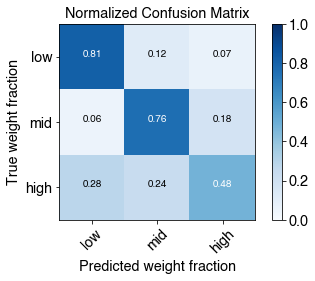

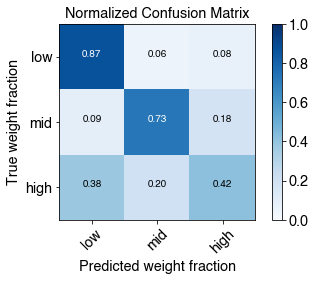

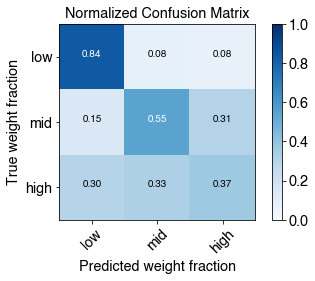

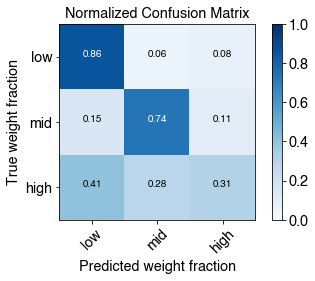

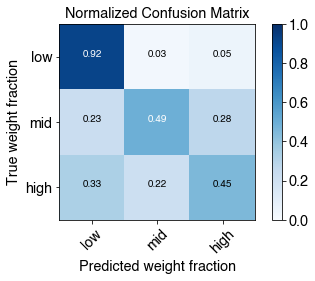

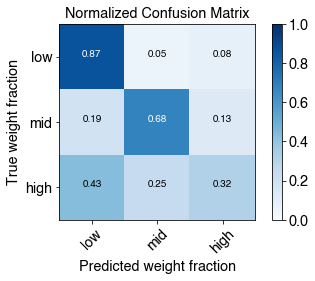

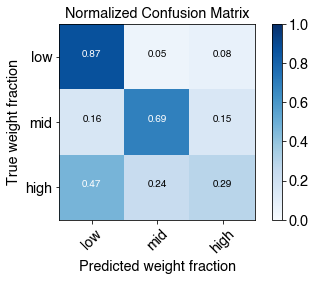

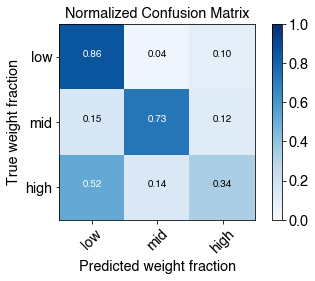

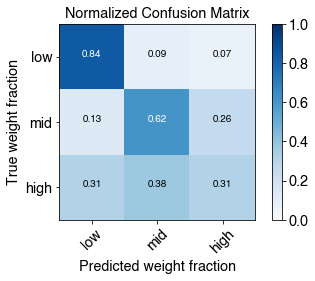

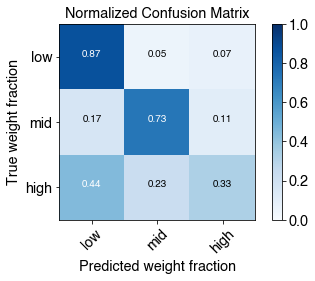

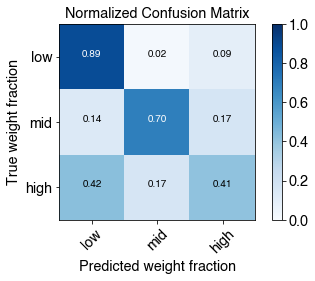

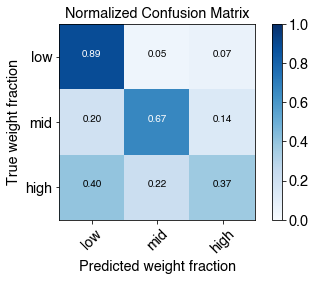

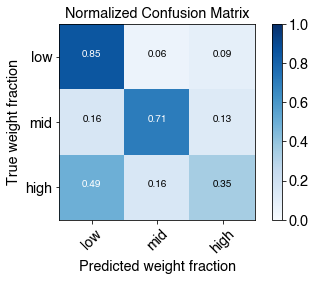

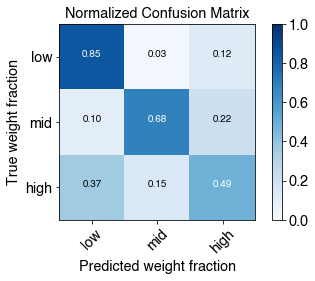

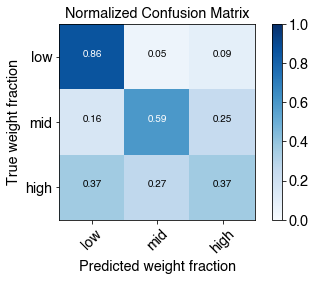

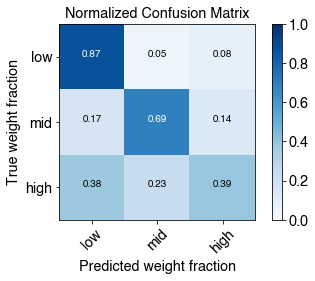

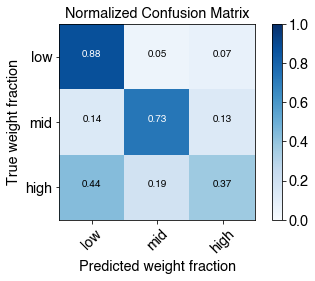

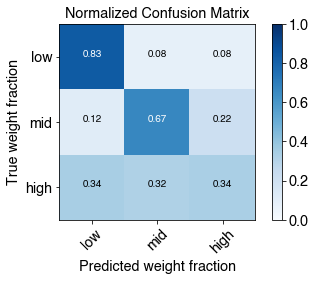

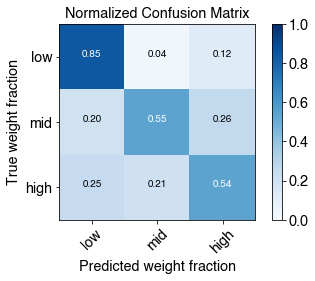

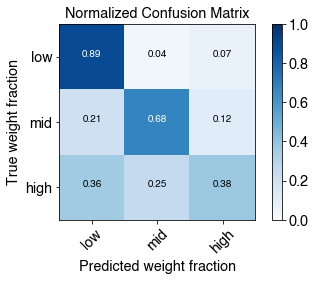

In [19]:
# SVC
results_svc = blt.run_hyperparams(
    results_prelim[results_prelim["estimator"] == "SVC"].astype(object),
    cust_folds=5,
    random_state=np.arange(100),
)

## RFC

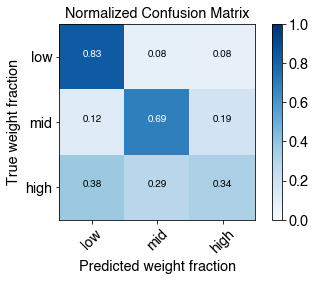

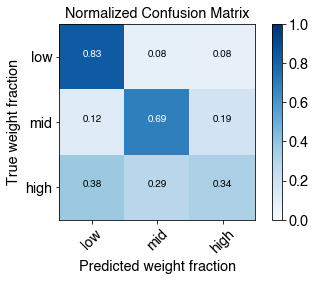

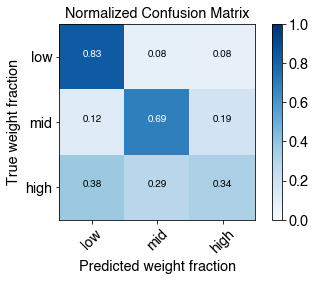

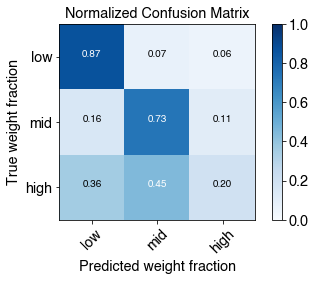

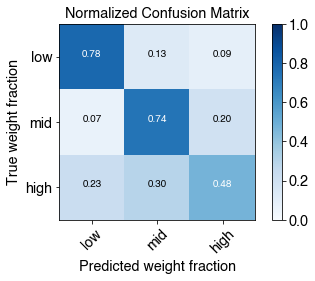

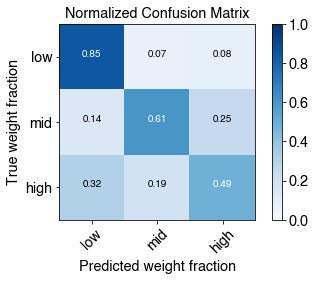

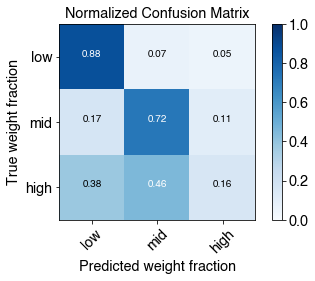

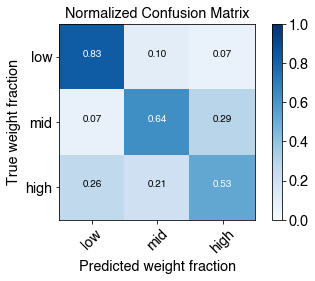

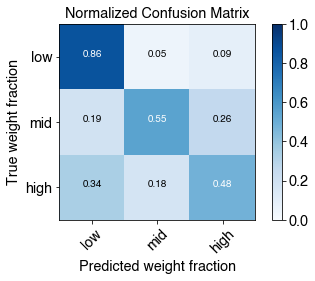

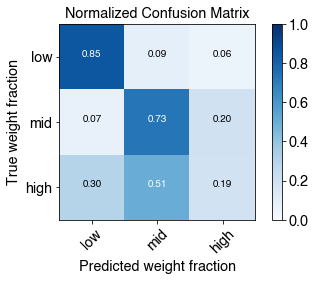

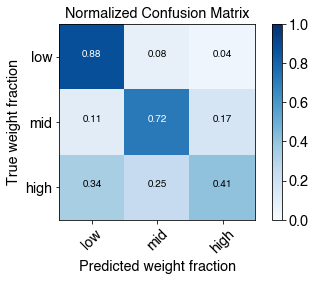

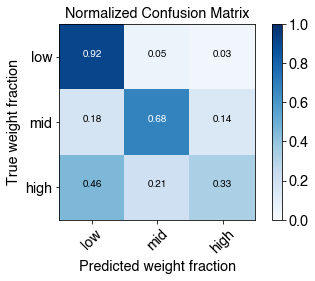

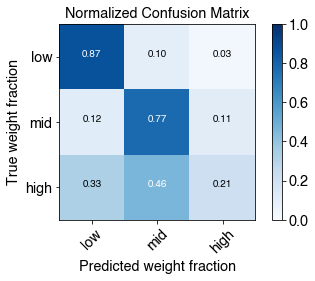

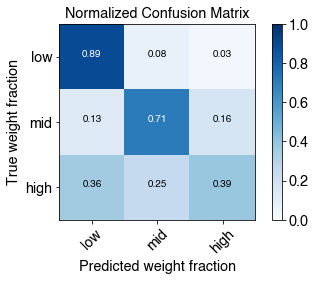

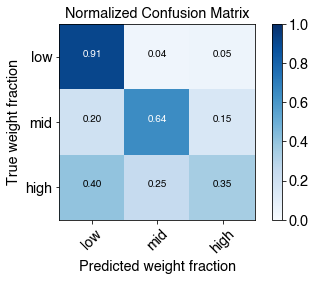

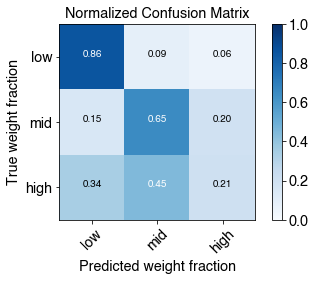

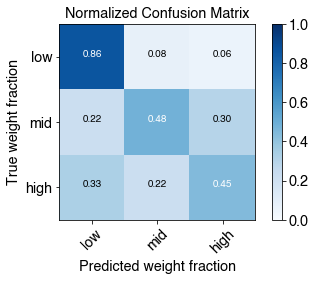

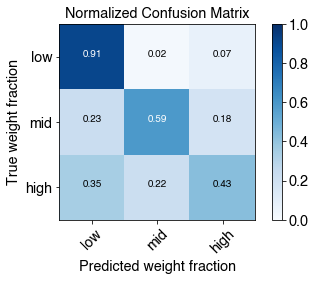

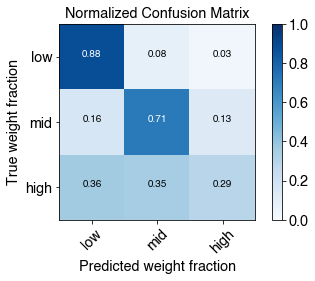

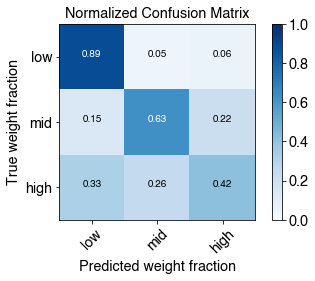

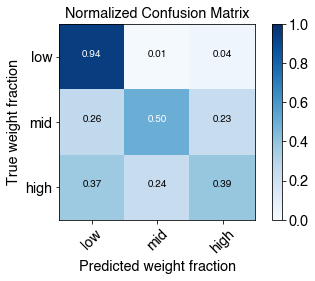

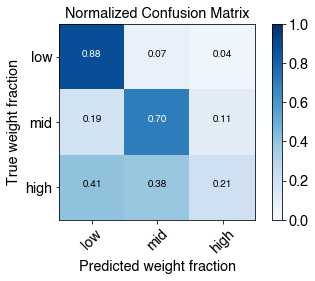

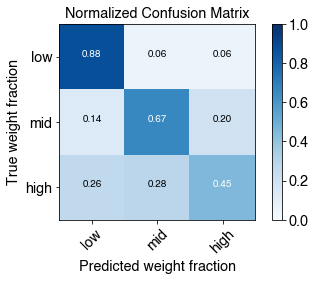

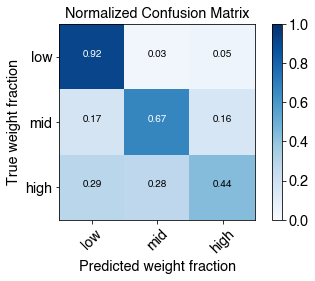

In [20]:
# RFC
results_rfc = blt.run_hyperparams(
    results_prelim[results_prelim["estimator"] == "RandomForestClassifier"],
    cust_folds=5,
    random_state=np.arange(100),
)

# Performance results

## Performance summary

Note that data augmentation was not performed on data frames only containing ENM data (non-permuted and permuted).

In [23]:
# Export results tables to .csv
results_svc.to_csv(
    "./data/results-SVC.csv", sep="\t", header="infer", na_rep="NaN", index=False
)
results_rfc.to_csv(
    "./data/results-RFC.csv", sep="\t", header="infer", na_rep="NaN", index=False
)

In [19]:
def display_table(df, df2=None):
    """Redisplay results as table for publication."""

    if isinstance(df2, pd.DataFrame):
        df = pd.concat([df, df2])

    # Tidy up labels, decimal places
    df["estimator"] = df["estimator"].str.replace("RandomForestClassifier", "RFC")
    # df.columns = [i.replace("_", " ") for i in df.columns.tolist()]
    df["augmentation_type"] = [i.split("_")[0] for i in df["augmentation_type"]]
    # df["std_err"] = [np.array(i).astype(float) for i in df["std_err"]]
    # df["std_err_avg"] = [np.average(i) for i in df["std_err"]]
    pd.set_option("display.precision", 3)

    # Pivot table
    table = df.pivot(
        index=["augmentation_k", "augmentation_type"],
        columns="estimator",
        values="score_avg",
    )
    # errors = df.pivot(
    #    index=["augmentation_k", "augmentation_type"],
    #    columns="estimator",
    #    values="std_err_avg",
    # )

    return table  # , errors

In [25]:
table_all = pd.DataFrame(display_table(results_rfc, results_svc))
table_all.to_latex("./data/texresults_all")

In [31]:
table_all

estimator                           RFC    SVC
augmentation_k augmentation_type              
0              random             0.621  0.649
               supervised         0.621  0.649
               unsupervised       0.621  0.649
1              random               0.6    0.6
               supervised         0.664  0.684
               unsupervised       0.646  0.671
2              random             0.588  0.587
               supervised         0.665  0.637
               unsupervised       0.633  0.622
3              random             0.591  0.621
               supervised         0.669  0.619
               unsupervised       0.643  0.642
4              random             0.618   0.59
               supervised         0.664  0.643
               unsupervised       0.636  0.664
5              random             0.573  0.643
               supervised         0.594  0.636
               unsupervised       0.644  0.674
10             random              0.63  0.607
               supervised         0.646  0.649
               unsupervised       0.612  0.659
20             random             0.598  0.612
               supervised         0.666  0.645
               unsupervised       0.674   0.65

To get error bars working: https://stackoverflow.com/questions/52035184/pandas-plot-line-graph-with-both-error-bars-and-markers

In [27]:
def line_plot(df, errors=None, save_fig_name=None):

    if isinstance(errors, pd.DataFrame):
        errors = errors.unstack(level=[1])
    pltstyle = [":", ":", ":", "-", "-", "-"]
    pltcolor = ["tab:olive", "royalblue", "navy"]
    myplot = df.unstack(level=[1]).plot(
        kind="line", subplots=False, style=pltstyle, color=pltcolor, yerr=errors
    )
    plt.title("Performance of Classification Models", pad=10)
    plt.xlabel("Augmentation $k$")
    plt.ylabel("Average Balanced Accuracy")
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.gca().legend(loc="lower center", bbox_to_anchor=(0.5, -0.45), ncol=2)
    if save_fig_name:
        fig = myplot.get_figure()
        blt.savepdf(fig, save_fig_name)

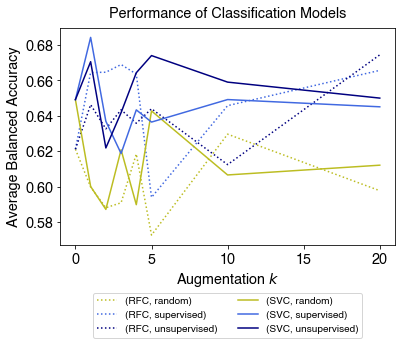

In [28]:
line_plot(df=table_all, errors=None, save_fig_name="bal-accu-plot")

## Permutation test

The following tests are performed with randomly permuted labels (ENM data only). This is to double check that the model is not overfitting.

In [26]:
# Define models and parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt

random_state = 1922
augmentation_kwargs = {
    "augmentation_random_state": random_state,
    "augmentation_X_source": X_source,
    "augmentation_y_source": bin_source,
}

models = {
    "RandomForestClassifier": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                RandomForestClassifier(
                    class_weight="balanced", random_state=random_state
                ),
            ),
        ],
        **augmentation_kwargs
    ),
    "SVC": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",  # balance by class size
                    random_state=random_state,
                ),
            ),
        ],
        **augmentation_kwargs
    ),
}
params = {
    "RandomForestClassifier": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0],
        "dimreducer__n_components": component_list,
        "estimator__max_depth": np.arange(2, 15, 2),
    },
    "SVC": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0],
        "dimreducer__n_components": component_list,
        "estimator__C": np.logspace(-1, 7, 9),
        "estimator__gamma": np.logspace(-7, 1, 9),
    },
}

[0.29 0.41 0.49 0.57 0.63 0.68 0.72 0.76 0.79 0.81 0.83 0.85 0.86 0.87
 0.89 0.9  0.91 0.92 0.92 0.93 0.94 0.95 0.95 0.96 0.96 0.97 0.97 0.98
 0.98 0.98 0.99 0.99 0.99 0.99 1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]


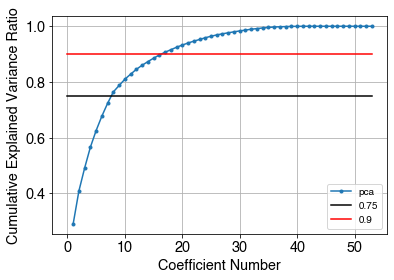

[8, 9, 10, 11, 12, 13, 14, 15, 16]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:   39.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=1)]: Done 3645 out of 3645 | elapsed:   45.8s finished


RandomForestClassifier
SVC


In [29]:
# Permutation test with y scrambled
# Hyperparameterization
component_list = blt.pca_precheck(
    X=X_enm, n_components=len(X_enm.columns), thres_btm=0.75, thres_top=0.9
)
results_prelim_permute = blt.apply_model_opt(
    models, 
    params, 
    X_target=X_enm, 
    y_target=np.random.RandomState().permutation(bin_enm), 
    cust_folds=5, 
    n_jobs=1
)

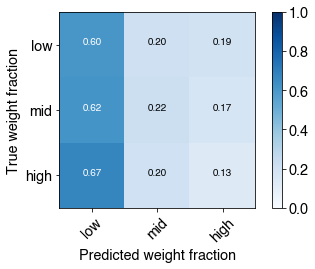

In [52]:
# Permutation test with y scrambled
# RFC evaluation
model_params = results_prelim_permute.loc[
    (results_prelim_permute["estimator"].str.contains("RandomForestClassifier"))
    & (results_prelim_permute["augmentation_k"] == 0)
]
model_params = model_params.head(1)
results_permute = blt.run_hyperparams(
    df_params=model_params,
    X=X_enm,
    y=np.random.RandomState().permutation(bin_enm),
    cust_folds=5,
)

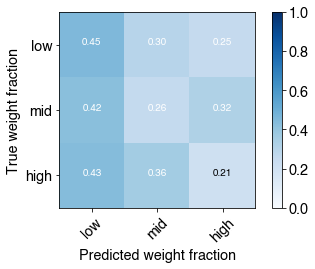

In [53]:
# Permutation test with y scrambled
# SVC evaluation
model_params = results_prelim_permute.loc[
    (results_prelim_permute["estimator"].str.contains("SVC"))
    & (results_prelim_permute["augmentation_k"] == 0)
]
model_params = model_params.head(1)
results_permute = results_permute.append(
    blt.run_hyperparams(
        df_params=model_params,
        X=X_enm,
        y=np.random.RandomState().permutation(bin_enm),
        cust_folds=5,
    )
)

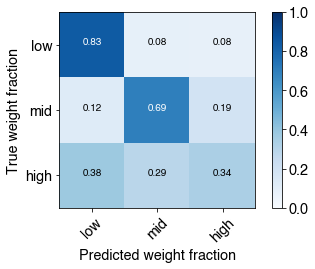

In [54]:
# Base test
# RFC evaluation
model_params = results_prelim.loc[
    (results_prelim["estimator"].str.contains("RandomForestClassifier"))
    & (results_prelim["augmentation_k"] == 0)
]
model_params = model_params.head(1)
results_permute = results_permute.append(
    blt.run_hyperparams(
        df_params=model_params,
        X=X_enm,
        y=bin_enm,
        cust_folds=5,
    )
)

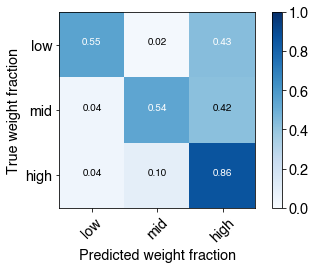

In [55]:
# Base test
# SVC evaluation
model_params = results_prelim.loc[
    (results_prelim["estimator"].str.contains("SVC"))
    & (results_prelim["augmentation_k"] == 0)
]
model_params = model_params.head(1)
results_permute = results_permute.append(
    blt.run_hyperparams(
        df_params=model_params,
        X=X_enm,
        y=bin_enm,
        cust_folds=5,
    )
)

In [58]:
results_permute

,estimator,augmentation_type,augmentation_k,score_avg,score_list,std_err
0,RandomForestClassifier,random_augment,0,0.316067,"[0.2888888888888889, 0.3177777777777778, 0.333...","[0.05305482838361476, 0.04382907316292449, 0.0..."
0,SVC,random_augment,0,0.305356,"[0.3, 0.2511111111111111, 0.28222222222222226,...","[0.06004113816047242, 0.049140765305546626, 0...."
0,RandomForestClassifier,random_augment,0,0.621178,"[0.5844444444444445, 0.5844444444444444, 0.619...","[0.07450246495217873, 0.0559541258311741, 0.04..."
0,SVC,random_augment,0,0.649156,"[0.6, 0.6511111111111112, 0.691111111111111, 0...","[0.05115939748098373, 0.07163005093904977, 0.0..."


In [59]:
# Export permutation results to text file
results_permute.to_csv(
    "./results/results-permute.txt", sep="\t", header="infer", na_rep="NaN", index=False
)

In [63]:
# Check normality of test results for permutations, baseline and best models
from scipy.stats import normaltest

for i in [
    results_permute.iloc[0, 4],
    results_permute.iloc[1, 4],
    results_permute.iloc[2, 4],
    results_permute.iloc[3, 4],
]:
    print(normaltest(i))

NormaltestResult(statistic=1.018872268366014, pvalue=0.60083427322254)
NormaltestResult(statistic=3.5099520293277293, pvalue=0.17291138957977983)
NormaltestResult(statistic=3.6283951911189507, pvalue=0.16296862268682763)
NormaltestResult(statistic=6.25260955942765, pvalue=0.04387964298768544)


The p-value of our first normality test is above alpha=0.05, so it is fairly safe to assume that the permutation test results can be adequately represented by a normal distribution. The distribution for the SVC does not pass, however. So a non-parametric test should be used for that data.

In [88]:
# Plot permutation test results
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


def plot_permutations(res_base, res_scrambled, save_fig_suffix):
    """
    Plot histograms and probability density functions for model results
    
    Arguments
    ---------
    res_base : list of floats
        List of scores for baseline model.
    res_scrambled : list of floats
        List of scores for model trained on permuted labels.
    save_fig_suffix : string
        Suffix to be used at the end of the figure filename.
    """
    # Plot histograms
    plt.rcParams["font.size"] = 12
    plt.hist(res_scrambled, bins=20, facecolor="orange", alpha=0.3)
    plt.hist(res_base, bins=20, facecolor="navy", alpha=0.3)

    # Stats for distributions
    mu_scrambled = np.mean(res_scrambled)
    mu_base = np.mean(res_base)
    std_scrambled = norm.fit(res_scrambled)[1]
    std_base = norm.fit(res_base)[1]
    x = np.linspace(0.2, 0.5, 100)
    x2 = np.linspace(0.45, 0.8, 100)

    # Plot PDFs
    plt.plot(
        x,
        norm.pdf(x, mu_scrambled, std_scrambled),
        color="orange",
        label="PDF permuted",
        alpha=0.8,
    )
    plt.plot(
        x2,
        norm.pdf(x2, mu_base, std_base),
        color="navy",
        label="PDF baseline",
        alpha=0.8,
    )

    # Plot averages
    plt.axvline(mu_scrambled, ls="--", c="orange", label="Avg. permuted")
    plt.axvline(mu_base, ls="--", c="navy", label="Avg. baseline")

    # Figure settings
    # plt.title("SVC-RBF Permutation Test Results")
    plt.xlim(right=0.8)
    plt.ylim(top=30)
    plt.xlabel("Balanced Accuracy")
    plt.ylabel("Frequency")
    plt.legend(loc=1, fontsize=12, ncol=2)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(5, 3)
    blt.savepdf(fig, "permutationtest_%s" % save_fig_suffix)
    plt.show()

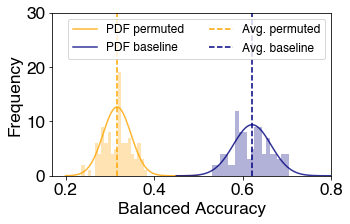

In [90]:
plot_permutations(
    res_base=results_permute.iloc[2, 4],
    res_scrambled=results_permute.iloc[0, 4],
    save_fig_suffix="RFC",
)

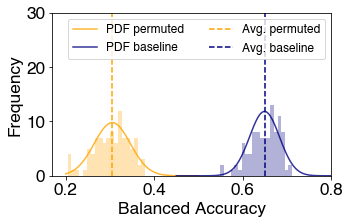

In [91]:
plot_permutations(
    res_base=results_permute.iloc[3, 4],
    res_scrambled=results_permute.iloc[1, 4],
    save_fig_suffix="SVC",
)

In [125]:
from scipy.stats import wilcoxon


def pair_signif(res_base, res_scrambled, estimator):
    """
    Test for significance of paired difference between model distributions.

    Input desired results dataframe to assess the difference between the two
    different model score distributions. Note the Wilcoxon signed-rank test is
    a non-parametric version of the paired T-test.
    https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.stats.wilcoxon.html
    """

    # Stats for distributions
    mu_base = "{:0.3f}".format(np.mean(res_base))
    mu_scrambled = "{:0.3f}".format(np.mean(res_scrambled))
    std_base = "{:0.3f}".format(norm.fit(res_base)[1])
    std_scrambled = "{:0.3f}".format(norm.fit(res_scrambled)[1])

    # Wilcoxon signed-rank test
    wilcoxon_res = wilcoxon(
        x=res_scrambled, y=res_base, alternative="less"
    )  # alternative='two-sided' # alternative='less'
    pvalue = "{:.2e}".format(wilcoxon_res[1] / 2)

    # Table of stats
    res_dict = {
        "Estimator": [estimator, ""],
        "Model conditions": ["baseline", "permuted labels"],
        "Avg. balanced accuracy": [mu_base, mu_scrambled],
        "Standard deviation": [std_base, std_scrambled],
        "p-value": ["", pvalue],
    }
    res = pd.DataFrame(res_dict)

    return res

In [126]:
res_wilcoxon = pair_signif(
    res_base=results_permute.iloc[2, 4],
    res_scrambled=results_permute.iloc[0, 4],
    estimator="RFC",
)
res_wilcoxon2 = pair_signif(
    res_base=results_permute.iloc[3, 4],
    res_scrambled=results_permute.iloc[1, 4],
    estimator="SVC",
)
res_wilcoxon = pd.concat([res_wilcoxon, res_wilcoxon2])
res_wilcoxon

,Estimator,Model conditions,Avg. balanced accuracy,Standard deviation,p-value
0,RFC,baseline,0.621,0.042,
1,,permuted labels,0.316,0.032,9.74e-19
0,SVC,baseline,0.649,0.034,
1,,permuted labels,0.305,0.041,9.73e-19


Our null hypothesis was that the balanced accuracies for our baseline models were the same as those of the models with permuted labels. The alternative hypothesis is that accuracies of the models with permuted labels are smaller than those of the baseline models. Because the p-value (divided by 2 for a one-tailed test) from the Wilcoxon signed-rank test was incredibly small in comparison to an alpha of 0.05, we can reject the null hypotheses. It is statistically likely that our models perform better than those trained on random labels.

In [127]:
blt.custom_latex(
    res_wilcoxon,
    "wilcoxon",
    tex_label="tab:wilcoxon",
    caption="One-tailed Wilcoxon signed-rank test results for permutation testing. Classifiers were trained on nanomaterials product data (data-poor framework) using weight fraction label data with and without permutation. RFC = a random forest classifier; SVC = a nonlinear support vector classifier.",
)

Results directory exists.
./results/wilcoxon.txt


# Feature comparison

Model optimization and evaluation is performed on the clustered ENM-only CP data after it is subset by groups of features: functions, PUCs, chemical properties and matrix properties. This serves as a means of comparing the usefulness of the different feature groups for classification.

In [16]:
def feat_comparison(list_col_idx):
    """Run hyperparameterization and model evaluation for a subset of features"""

    # Select subset of features
    X = X_enm.iloc[:, list_col_idx]

    # Find range of PCA components to test during hyperparameterization
    component_list = blt.pca_precheck(
        X=X, n_components=len(list_col_idx), thres_btm=0.75, thres_top=0.9
    )

    # Define models and parameters
    models = {
        "RandomForestClassifier": blt.AugmentingPipeline(
            [
                ("scaler", MinMaxScaler()),  # normalization from 0 to 1
                ("dimreducer", PCA()),
                (
                    "estimator",
                    RandomForestClassifier(
                        class_weight="balanced", random_state=random_state
                    ),
                ),
            ],
            **augmentation_kwargs
        ),
        "SVC": blt.AugmentingPipeline(
            [
                ("scaler", MinMaxScaler()),  # normalization from 0 to 1
                ("dimreducer", PCA()),
                (
                    "estimator",
                    SVC(
                        kernel="rbf",
                        class_weight="balanced",  # balance by class size
                        random_state=random_state,
                    ),
                ),
            ],
            **augmentation_kwargs
        ),
    }
    params = {
        "RandomForestClassifier": {
            "augmentation_type": [random_augment],
            "augmentation_k": [0],  # no augmentation
            "dimreducer__n_components": component_list,
            "estimator__max_depth": np.arange(2, 19, 2),
        },
        "SVC": {
            "augmentation_type": [random_augment],
            "augmentation_k": [0],  # no augmentation
            "dimreducer__n_components": component_list,
            "estimator__C": np.logspace(-1, 7, 9),
            "estimator__gamma": np.logspace(-7, 1, 9),
        },
    }

    # Hyperparameterization
    results_prelim = blt.apply_model_opt(
        models, params, X_target=X, y_target=bin_enm, cust_folds=5, n_jobs=1
    )

    # Model evaluation
    results_rfc = blt.run_hyperparams(
        results_prelim[results_prelim["estimator"] == "RandomForestClassifier"],
        cust_folds=5,
        random_state=np.arange(100),
        fig_name_prefix="enm_feats_" + str(list_col_idx),
    )
    results_svc = blt.run_hyperparams(
        results_prelim[results_prelim["estimator"] == "SVC"].astype(object),
        cust_folds=5,
        random_state=np.arange(100),
        fig_name_prefix="enm_feats_" + str(list_col_idx),
    )
    table_all = display_table(results_rfc, results_svc)

    return table_all

In [17]:
# Get column indices for groups of features
# Feature groups: chemical properties, functional uses,
# product categories, matrix properties, WF_measured
feat_names = X_enm.columns
idx_cprponly = [i for i, s in enumerate(feat_names) if "cprp" in s]
idx_funconly = [i for i, s in enumerate(feat_names) if "func" in s]
idx_pcatonly = [i for i, s in enumerate(feat_names) if "pgen" in s]
idx_pcatonly += [i for i, s in enumerate(feat_names) if "pgrp" in s]
idx_mtrxonly = [i for i, s in enumerate(feat_names) if "mtrx" in s]
del idx_mtrxonly[-1]  # do not include mtrx_WFmeasured

print("Chemical property column indices", idx_cprponly)
print("Functional use column indices\t", idx_funconly)
print("Matrix property column indices\t", idx_mtrxonly)
print("Was WF measured? index\t\t", [-1])
print("Product category column indices\t", idx_pcatonly)

Chemical property column indices [0, 1, 2, 3]
Functional use column indices	 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Matrix property column indices	 [50, 51]
Was WF measured? index		 [-1]
Product category column indices	 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


[0.29 0.41 0.49 0.57 0.63 0.68 0.72 0.76 0.79 0.81 0.83 0.85 0.86 0.87
 0.89 0.9  0.91 0.92 0.92 0.93 0.94 0.95 0.95 0.96 0.96 0.97 0.97 0.98
 0.98 0.98 0.99 0.99 0.99 0.99 1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]


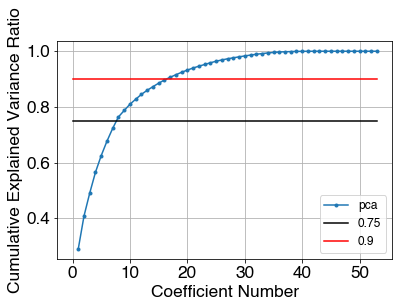

[8, 9, 10, 11, 12, 13, 14, 15, 16]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=1)]: Done 3645 out of 3645 | elapsed:   48.6s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.621,0.649,all


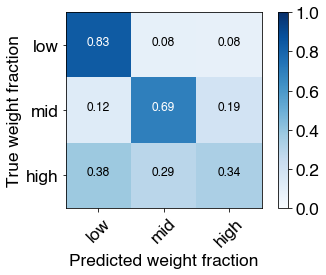

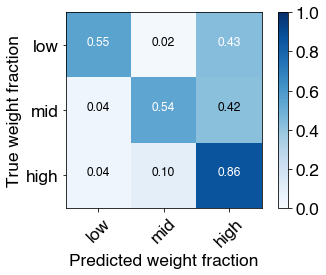

In [22]:
# All ENM feature data
res_all = feat_comparison(np.arange(0, len(X_enm.columns)))
res_all["features"] = "all"
res_all

[0.51 0.89 0.98 1.  ]


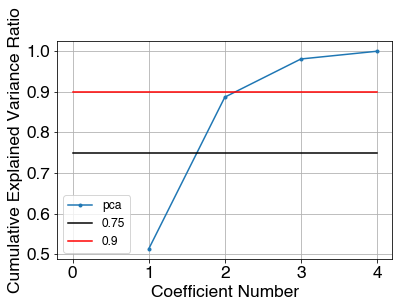

[2]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:    7.6s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.683,0.682,chemical properties


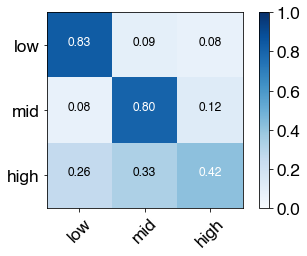

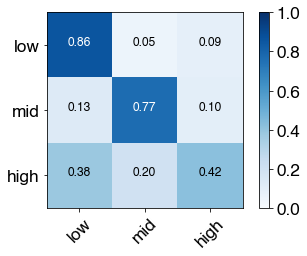

In [34]:
# Only chemical property features
res_cprp = feat_comparison(idx_cprponly)
res_cprp["features"] = "chemical properties"
res_cprp

[0.37 0.51 0.64 0.75 0.82 0.86 0.89 0.91 0.93 0.95 0.97 0.98 0.99 0.99
 1.   1.  ]


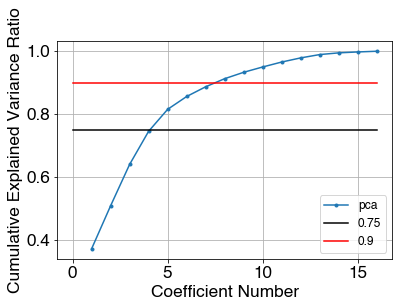

[5, 6, 7]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   24.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:   14.5s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.657,0.728,functional uses


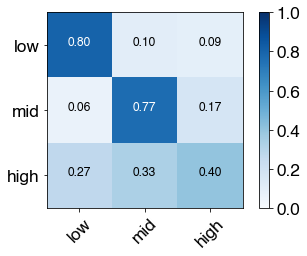

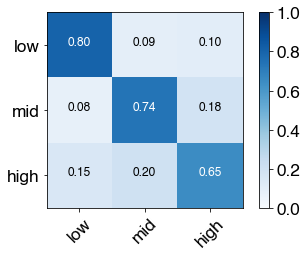

In [31]:
# Only functional use features
res_func = feat_comparison(idx_funconly)
res_func["features"] = "functional uses"
res_func

[0.33 0.46 0.54 0.62 0.67 0.71 0.76 0.79 0.82 0.85 0.87 0.89 0.91 0.92
 0.94 0.95 0.96 0.97 0.98 0.99 0.99 1.   1.   1.   1.   1.   1.   1.
 1.   1.  ]


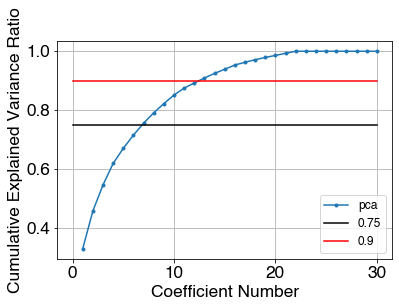

[7, 8, 9, 10, 11, 12]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   43.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:   24.0s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.607,0.583,product categories


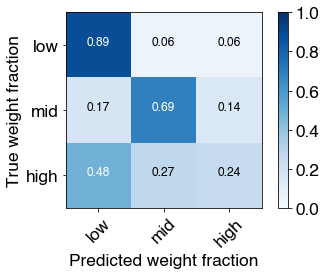

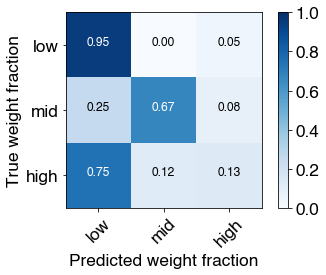

In [24]:
# Only product category features
res_pcat = feat_comparison(idx_pcatonly)
res_pcat["features"] = "product categories"
res_pcat

[0.6 1. ]


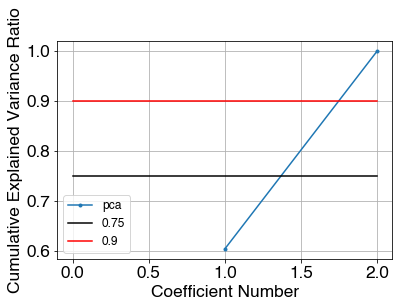

[2]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:    3.9s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.664,0.666,matrix properties


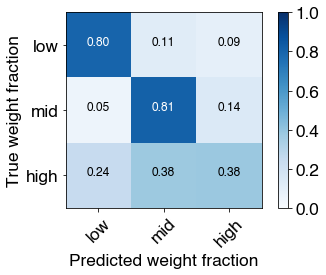

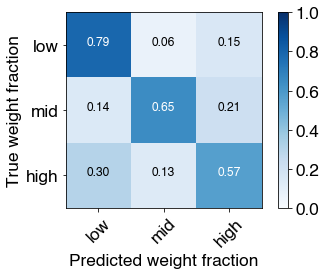

In [25]:
# Only matrix property features
res_mtrx = feat_comparison(idx_mtrxonly)
res_mtrx["features"] = "matrix properties"
res_mtrx

[0.37 0.5  0.62 0.72 0.8  0.84 0.87 0.89 0.91 0.93 0.95 0.96 0.97 0.98
 0.99 0.99 1.   1.   1.   1.  ]


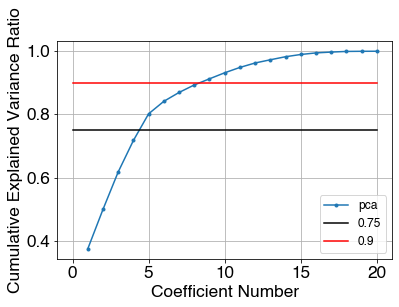

[5, 6, 7, 8]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   28.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:   18.6s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.657,0.661,chem. properties & functional uses


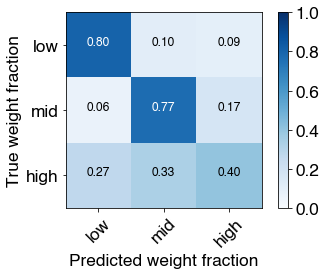

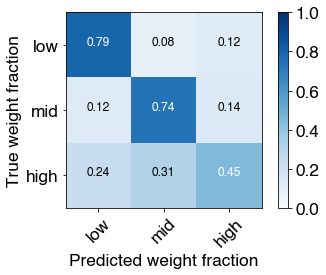

In [26]:
# Chem property & functional use features
res_cpfu = feat_comparison(idx_cprponly + idx_funconly)
res_cpfu["features"] = "chem. properties & functional uses"
res_cpfu

[0.36 0.5  0.61 0.7  0.78 0.84 0.87 0.89 0.91 0.93 0.94 0.96 0.97 0.98
 0.99 0.99 1.   1.   1.   1.   1.  ]


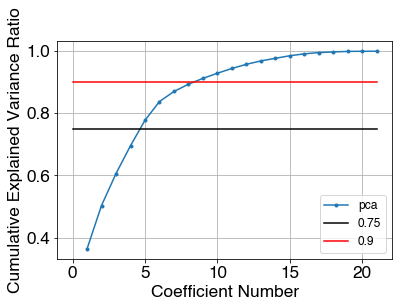

[5, 6, 7, 8]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   33.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:   18.4s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.648,0.732,without product & matrix info


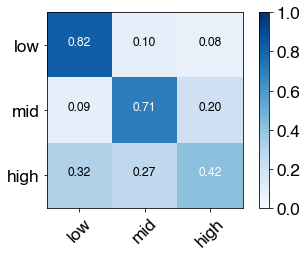

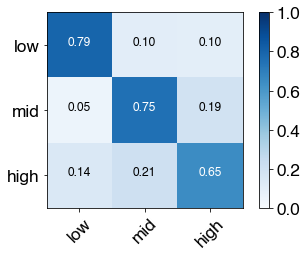

In [33]:
# Chem props & functional uses & WF_measured
res_cfwf = feat_comparison(idx_cprponly + idx_funconly + [-1])
res_cfwf["features"] = "without product & matrix info"
res_cfwf

[0.32 0.46 0.56 0.65 0.72 0.79 0.84 0.87 0.89 0.91 0.93 0.94 0.95 0.96
 0.97 0.98 0.99 0.99 1.   1.   1.   1.   1.  ]


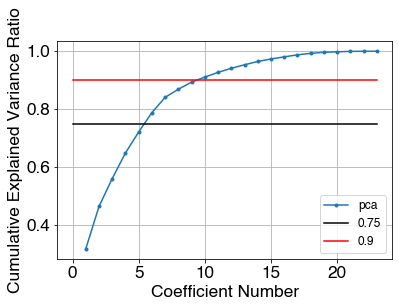

[6, 7, 8, 9]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   29.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:   17.4s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.648,0.712,without product info


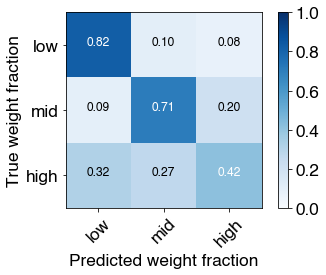

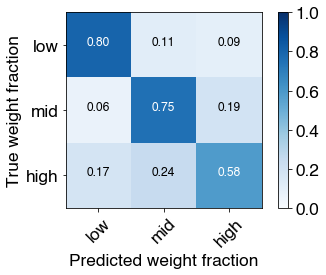

In [28]:
# Chem props & functional uses & matrix props & WF_measured
res_cfmw = feat_comparison(idx_cprponly + idx_funconly + idx_mtrxonly + [-1])
res_cfmw["features"] = "without product info"
res_cfmw

[0.29 0.41 0.5  0.57 0.64 0.69 0.73 0.76 0.79 0.81 0.83 0.84 0.86 0.87
 0.88 0.9  0.91 0.92 0.93 0.93 0.94 0.95 0.95 0.96 0.96 0.97 0.97 0.98
 0.98 0.98 0.99 0.99 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]


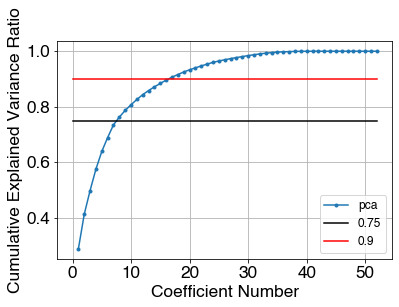

[8, 9, 10, 11, 12, 13, 14, 15, 16]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=1)]: Done 3645 out of 3645 | elapsed:   49.0s finished


RandomForestClassifier
SVC


,estimator,RFC,SVC,features
augmentation_k,augmentation_type,,,
0,random,0.577,0.65,without WF_measured


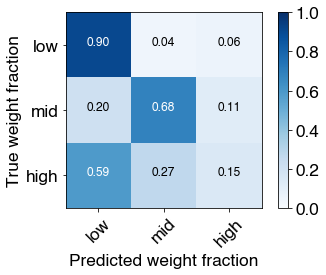

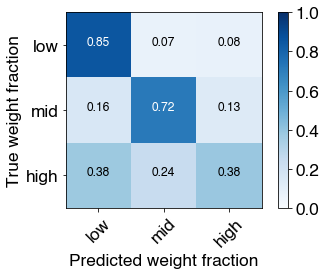

In [29]:
# Chem props & functional uses
res_nowf = feat_comparison(np.arange(52))
res_nowf["features"] = "without WF_measured"
res_nowf

## Comparison summary

In [33]:
res_feat_comparison = pd.concat(
    [
        res_cprp,
        res_func,
        res_pcat,
        res_mtrx,
        res_cpfu,
        res_cfwf,
        res_cfmw,
        res_nowf,
        res_all,
    ],
    axis=0,
)
res_feat_comparison.reset_index(drop=True, inplace=True)
res_feat_comparison

estimator,RFC,SVC,features
0,0.683,0.682,chemical properties
1,0.657,0.728,functional uses
2,0.607,0.583,product categories
3,0.664,0.666,matrix properties
4,0.657,0.661,chem. properties & functional uses
5,0.648,0.732,without product & matrix info
6,0.648,0.712,without product info
7,0.577,0.65,without WF_measured
8,0.621,0.649,all


In [34]:
feat_table = pd.DataFrame(
    {
        "Chemical properties": ["X", "", "", "", "X", "X", "X", "X", "X"],
        "Functional uses": ["", "X", "", "", "X", "X", "X", "X", "X"],
        "Product categories": ["", "", "X", "", "", "", "", "X", "X"],
        "Matrix properties": ["", "", "", "X", "", "", "X", "X", "X"],
        "WF measured?": ["", "", "", "", "", "X", "X", "", "X"],
    }
)
feat_compare_final = pd.concat(
    [feat_table, res_feat_comparison], axis=1
)
feat_compare_final = feat_compare_final.infer_objects().round(decimals=3)
feat_compare_final.drop(columns="features", inplace=True)
feat_compare_final

,Chemical properties,Functional uses,Product categories,Matrix properties,WF measured?,RFC,SVC
0,X,,,,,0.683,0.682
1,,X,,,,0.657,0.728
2,,,X,,,0.607,0.583
3,,,,X,,0.664,0.666
4,X,X,,,,0.657,0.661
5,X,X,,,X,0.648,0.732
6,X,X,,X,X,0.648,0.712
7,X,X,X,X,,0.577,0.650
8,X,X,X,X,X,0.621,0.649


In [37]:
# Load results (LaTeX file) for organics product data

# Converter to delete LaTeX line terminator
def convert_txt(txt):
    new_txt = txt.split(" ")[0]
    return new_txt


# Read file
feat_compare_organics = pd.read_csv(
    "./results/feat-compare-organics.txt",
    sep="&",
    index_col=False,
    names=list(feat_compare_final.columns),
    skipinitialspace=True,
    skiprows=5,
    converters={-1: convert_txt},
    skipfooter=5,
).infer_objects()
feat_compare_organics

,Chemical properties,Functional uses,Product categories,Matrix properties,WF measured?,RFC,SVC
0,X,NaN,NaN,NaN,NaN,0.689,0.572
1,NaN,X,NaN,NaN,NaN,0.587,0.578
2,NaN,NaN,X,NaN,NaN,0.426,0.426
3,NaN,NaN,NaN,X,NaN,0.389,0.389
4,X,X,NaN,NaN,NaN,0.693,0.68
5,X,X,NaN,NaN,X,0.693,0.68
6,X,X,NaN,X,X,0.674,0.655
7,X,X,X,X,NaN,0.624,0.616
8,X,X,X,X,X,0.617,0.616


In [38]:
# Concatenate results
feat_compare_all = pd.concat(
    [feat_compare_final, feat_compare_organics.iloc[:, -2:]], axis=1
)
feat_compare_all

,Chemical properties,Functional uses,Product categories,Matrix properties,WF measured?,RFC,SVC,RFC,SVC
0,X,,,,,0.683,0.682,0.689,0.572
1,,X,,,,0.657,0.728,0.587,0.578
2,,,X,,,0.607,0.583,0.426,0.426
3,,,,X,,0.664,0.666,0.389,0.389
4,X,X,,,,0.657,0.661,0.693,0.68
5,X,X,,,X,0.648,0.732,0.693,0.68
6,X,X,,X,X,0.648,0.712,0.674,0.655
7,X,X,X,X,,0.577,0.650,0.624,0.616
8,X,X,X,X,X,0.621,0.649,0.617,0.616


In [39]:
blt.custom_latex(feat_compare_all, "feat-compare-all")

Results directory exists.
./results/feat-compare-all.txt
